In [1]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import mlflow
from sklearn.metrics import f1_score, recall_score, precision_score

from modules.gnnad.graphanomaly_cleaned import GNNAD, create_model_copy
from modules.gnnad.cross_val_func import drop_anomalous_points, test_set_windows, get_anomalies_by_feature
from modules.gnnad.plot import plot_feature_error_scores, plot_time_series_with_anomalies, plot_predictions_and_anomalies

# Set the environment variable within your Python script for enabling deterministic algorithms
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # or ':16:8'

In [2]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")

# Sets the current active experiment to the "Apple_Models" experiment and
# returns the Experiment metadata
apple_experiment = mlflow.set_experiment("anomaly_detection")

# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "GNNAD_cross_validation"

# Define an artifact path that the model will be saved to.
artifact_path = "GNNAD_cross_validation_loggings"

### For labeled dataset

In [3]:
try:
    df_loaded
except NameError: # read in training data
    # read in test data
    df_loaded = pd.read_csv('for_cross_validation.csv', index_col=0)
    df_loaded.index = pd.to_datetime(df_loaded.index)

df = df_loaded.copy()

## Cross-validation

In [4]:
scaler = preprocessing.StandardScaler()

def prepare_sets(train, test, scaler=scaler):

    train_set = train.drop(columns=['Fault'])
    test_set = test.drop(columns=['Fault'])
    train_labels = train[['Fault']].apply(any, axis=1)
    test_labels = test[['Fault']].apply(any, axis=1)

    # Normalize the data
    train_set_scaled = scaler.fit_transform(train_set)
    test_set_scaled = scaler.transform(test_set)

    train_df = pd.DataFrame(train_set_scaled, columns=train_set.columns, index=train_set.index)
    test_df = pd.DataFrame(test_set_scaled, columns=test_set.columns, index=test_set.index)

    return train_df, test_df, test_labels, train_labels


In [5]:
import warnings

# Ignore specific user warnings about non-deterministic operations
warnings.filterwarnings("ignore", message="scatter_reduce_cuda does not have a deterministic implementation")

In [6]:
params = {}
model_params = {}

model_params['epoch'] = 1
model_params['topk'] = 11                        # 11 seems to work the best. number of top-k neighbors to consider for each node when creating the learned graph structure
model_params['errors_topk'] = 11                  # 7 seems to work the best. Number of top-k errors to consider for detecting anomalies
model_params['slide_win'] = 15                   # Window size. 15 seems to work well
model_params['slide_stride'] = 1                 # Stride size. 2 seems to work well
model_params['device'] = "cuda"
model_params['shuffle_train'] = False             # Shuffles the training set after validation set was created, False seems to work much better
model_params['smoothen_error'] = False            # Smoothen the error scores. Using False will increase the precision and reduce the number of false positives
model_params['validation_size'] = 300
model_params['batch'] = 64                      # 256 seems to work well
model_params['early_stop_win'] = 20
model_params['loss_func'] = "mse"                # "mse" or "mae". MSE seems to work better overall.
model_params['threshold_multiplier'] = 1.2       # 1.2 seems to work well
model_params['use_deterministic'] = True
model_params['input_column_names'] = df.columns[:-1].tolist()           # Names of the input columns except the 'Fault' column

In [7]:
def rolling_median_filter(data, window=5):
    return data.rolling(window=window, center=True, min_periods=1).median()

In [8]:
df = df_loaded.copy()
df_removed_anom = df_loaded.copy()
window_size = model_params['slide_win']

# Store results
f1_score_list, recall_list, precision_list = [], [], []
train_fold_data, test_fold_data = [], []
false_pos_list, fp_rate_list = [], []
fold_metrics = []

min_inference_size = model_params['slide_win'] + 1
min_train_size = model_params['validation_size'] + model_params['slide_win'] + 450

model = GNNAD(**model_params)

# Since we need some data to train the model, we will start predicting from the days_ahead days onwards
days_ahead = 20
start_date = df.index.min().date() + pd.Timedelta(days=days_ahead)

# Group the data by day
df_daily = df[start_date:].groupby(df[start_date:].index.date)
fold = 0

# Iterate through each day
for day, day_data in df_daily:
    # Define test set as the current day's data
    test = day_data

    # Ensure we have at least min_test_size of data for testing, skip the fold if not
    if len(test) < min_inference_size:
        print(f"Skipping day {day} as test set is too small")
        continue

    # Define training set as all data before the current day
    train_end = pd.to_datetime(day) - pd.Timedelta(days=1)
    train_start = train_end - pd.Timedelta(days=1)
    train = df_removed_anom[train_start:train_end]

    # Ensure we have at least min_train_days of data for training
    while len(train) <= min_train_size:
        train_start -= pd.Timedelta(days=1)
        train = df_removed_anom[train_start:train_end]

    train_set, test_set, test_labels, train_labels = prepare_sets(train, test)
    train_set = rolling_median_filter(train_set, window=3)
    
    # Fit the model on the training data
    model.fit(train_set, time_index=train_set.index)
    
    # Prepare test data for inference
    test_windows = test_set_windows(test_set, window_size)
    all_predicted_labels = []
    for test_window in test_windows:
        test_window = rolling_median_filter(test_window, window=3)

        start_time = time.perf_counter()
        predicted_labels = model.predict(test_window, time_index=test_window.index) # it will return red anomalies
        end_time = time.perf_counter()
        all_predicted_labels.extend(predicted_labels)

    # Create a model copy
    model_copy = create_model_copy(model, model_params)
    train_fold_data.append((fold, model_copy, train_set, train_labels))
    test_fold_data.append((fold, model_copy, test_set, test_labels, all_predicted_labels))

    df_removed_anom = drop_anomalous_points(df_removed_anom, all_predicted_labels, test, window_size=window_size)
    
    # Calculate the number of false positives and the false positive rate
    fps = sum([1 for true, pred in zip(test_labels[window_size:], all_predicted_labels) if true == 0 and pred == 1])
    fp_rate = fps / len(test_labels)

    false_pos_list.append(fps)
    fp_rate_list.append(fp_rate)

    # Evaluate performance
    if True in test_labels.values:  # If there are anomalies in the test set
        test_labels = test_labels[window_size:]
        f1 = f1_score(test_labels, all_predicted_labels)
        recall = recall_score(test_labels, all_predicted_labels)
        precision = precision_score(test_labels, all_predicted_labels)
        f1_score_list.append(f1)
        recall_list.append(recall)
        precision_list.append(precision)
    
        print(f"Fold {fold} - F1: {f1}, Recall: {recall}, Precision: {precision}, Number of FP: {fps}, FP Rate: {fp_rate}")
        fold_metrics.append((fold, True, f1, recall, precision, fps, fp_rate))
    else:  # If there are no anomalies in the test set

        print(f"Fold {fold} - Number of FP: {fps}, FP Rate: {fp_rate}")
        fold_metrics.append((fold, False, fps, fp_rate))
    
    fold += 1

# Average performance across folds
average_f1 = np.mean(f1_score_list)
average_recall = np.mean(recall_list)
average_precision = np.mean(precision_list)
average_fps = np.mean(false_pos_list)
average_fp_rate = np.mean(fp_rate_list)

print(f"Average F1: {average_f1}, Average Recall: {average_recall}, Average Precision: {average_precision}")
print(f"Average Number of FP: {average_fps}, Average FP Rate: {average_fp_rate}")

Fold 0 - Number of FP: 0, FP Rate: 0.0
Skipping day 2021-11-18 as test set is too small
Fold 1 - Number of FP: 0, FP Rate: 0.0
Fold 2 - Number of FP: 4, FP Rate: 0.08
Fold 3 - Number of FP: 0, FP Rate: 0.0
Fold 4 - Number of FP: 1, FP Rate: 0.014925373134328358
Fold 5 - Number of FP: 0, FP Rate: 0.0
Fold 6 - Number of FP: 0, FP Rate: 0.0
Fold 7 - Number of FP: 0, FP Rate: 0.0
Fold 8 - Number of FP: 7, FP Rate: 0.1044776119402985
Fold 9 - Number of FP: 1, FP Rate: 0.014925373134328358
Fold 10 - Number of FP: 3, FP Rate: 0.04477611940298507
Fold 11 - Number of FP: 0, FP Rate: 0.0
Fold 12 - Number of FP: 1, FP Rate: 0.034482758620689655
Fold 13 - Number of FP: 0, FP Rate: 0.0
Fold 14 - Number of FP: 0, FP Rate: 0.0
Fold 15 - Number of FP: 0, FP Rate: 0.0
Fold 16 - Number of FP: 2, FP Rate: 0.029850746268656716
Fold 17 - Number of FP: 7, FP Rate: 0.10294117647058823
Fold 18 - Number of FP: 4, FP Rate: 0.125
Fold 19 - Number of FP: 0, FP Rate: 0.0
Fold 20 - Number of FP: 1, FP Rate: 0.01515

d:\PROJECTS\ANOMALY_DETECTION\anomaly_detection_development\GNNAD\GNNAD_training\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold 37 - F1: 0.0, Recall: 0.0, Precision: 0.0, Number of FP: 0, FP Rate: 0.0
Fold 38 - Number of FP: 0, FP Rate: 0.0
Fold 39 - Number of FP: 4, FP Rate: 0.05970149253731343
Fold 40 - F1: 0.7692307692307693, Recall: 1.0, Precision: 0.625, Number of FP: 15, FP Rate: 0.22058823529411764
Fold 41 - F1: 0.7536231884057972, Recall: 0.9285714285714286, Precision: 0.6341463414634146, Number of FP: 15, FP Rate: 0.21739130434782608
Fold 42 - Number of FP: 0, FP Rate: 0.0
Fold 43 - F1: 0.8764044943820225, Recall: 0.78, Precision: 1.0, Number of FP: 0, FP Rate: 0.0
Fold 44 - F1: 0.6666666666666667, Recall: 0.5952380952380952, Precision: 0.7575757575757576, Number of FP: 8, FP Rate: 0.11764705882352941
Fold 45 - Number of FP: 0, FP Rate: 0.0
Fold 46 - Number of FP: 1, FP Rate: 0.014492753623188406
Fold 47 - Number of FP: 0, FP Rate: 0.0
Fold 48 - Number of FP: 0, FP Rate: 0.0
Fold 49 - Number of FP: 4, FP Rate: 0.058823529411764705
Fold 50 - F1: 0.3870967741935484, Recall: 0.3333333333333333, Preci

In [9]:
params = model_params.copy()
params['scaler'] = scaler

metrics = {
    "average_f1": average_f1,
    "average_recall": average_recall,
    "average_precision": average_precision,
    "average_fps": average_fps,
    "average_fp_rate": average_fp_rate,
    "inference_time": end_time - start_time
}

# Open a file to write
with open("metrics_summary.txt", "w") as file:
    for fold_data in fold_metrics:
        fold = fold_data[0]
        has_anomalies = fold_data[1]
        
        if has_anomalies:  # If there are anomalies in the test set, print F1, Recall, Precision, FP, and FP Rate
            f1, recall, precision, fps, fp_rate = fold_data[2], fold_data[3], fold_data[4], fold_data[5], fold_data[6]
            line = f"Fold {fold} - F1: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Number of FP: {fps}, FP Rate: {fp_rate:.4f}\n"
        else:  # If there are no anomalies in the test set, print number of false positives and false positive rate
            fps, fp_rate = fold_data[2], fold_data[3]
            line = f"Fold {fold} - Number of FP: {fps}, FP Rate: {fp_rate:.4f}\n"
        
        file.write(line)
    
    # Write average metrics
    file.write("\nAverage Metrics:\n")
    file.write(f"Average F1: {average_f1:.4f}\n")
    file.write(f"Average Recall: {average_recall:.4f}\n")
    file.write(f"Average Precision: {average_precision:.4f}\n")
    file.write(f"Average Number of FP: {average_fps:.2f}\n")
    file.write(f"Average FP Rate: {average_fp_rate:.4f}\n")

with mlflow.start_run(run_name=run_name) as run:
    mlflow.log_params(params)
    mlflow.log_metrics(metrics)
    mlflow.log_artifact("for_cross_validation.csv")
    mlflow.log_artifact("GNNAD_cross_validation.ipynb")
    mlflow.log_artifact("modules/gnnad/plot.py")
    mlflow.log_artifact("modules/gnnad/utils.py")
    mlflow.log_artifact("modules/gnnad/graphanomaly_cleaned.py")
    mlflow.log_artifact("metrics_summary.txt")

## Plot TEST SET GROUND TRUTH VS PREDICTED VALUES

In [10]:
fold_num = 2
fold, saved_model, test_set, labels, predictions = test_fold_data[fold_num]

ground_labels = labels[window_size:] # Remove the first window_size samples from the labels

# convert the predictions to boolean and create a pandas series
boolean_predictions = list(map(bool, predictions))
predictions_df = pd.Series(boolean_predictions, index=ground_labels.index)

predicted_red_anomalies = saved_model.predict(test_set, time_index=test_set.index)
predicted_yellow_anomalies = saved_model.pred_labels_yellow

ground_values = saved_model.test_result[1]
ground_values_df = pd.DataFrame(ground_values, columns=saved_model.input_column_names, index=ground_labels.index)

predicted_values = saved_model.test_result[0]
predicted_values_df = pd.DataFrame(predicted_values, columns=saved_model.input_column_names, index=ground_labels.index)

# Call the function
# plot_predictions_and_anomalies(ground_values_df, predicted_values_df, ground_labels, predictions_df)

In [49]:
test_set = test_set[:window_size+15]

predicted_red_anomalies = model.predict(test_set, time_index=test_set.index)
predicted_yellow_anomalies = model.pred_labels_yellow

output = get_anomalies_by_feature(saved_model, predicted_yellow_anomalies, predicted_red_anomalies, test_set.index)
output

{'result': True,
 'anomaly_score': 1.0315847509879281,
 'anomalies': {'yellow': True,
  'red': False,
  'yellow_anomalies': {'energy_injected': ['20211206104000', '20211206110000'],
   'pv_plant_voltage': ['20211206104000'],
   'panel_temperature': ['20211206111000'],
   'power_injected': ['20211206111000'],
   'current_injected': ['20211206111000'],
   'grid_voltage': ['20211206111000']},
  'red_anomalies': {}}}

## Plot VALIDATION SET GROUND TRUTH AND PREDICTED VALUES

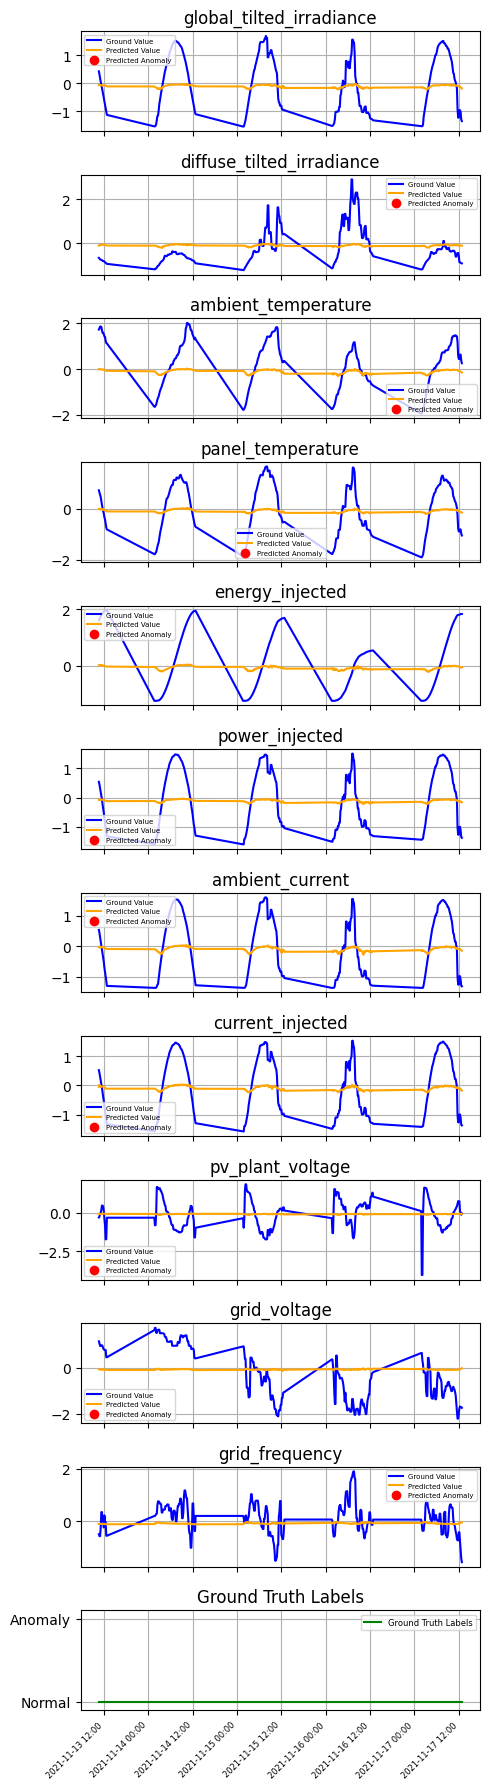

In [12]:
fold_num = 1
fold, model, train_set, labels = train_fold_data[fold_num]

val_set = train_set[-model_params['validation_size']:] # Get the last samples from the training set to use as the validation set
ground_labels = labels[-len(val_set)+model_params['slide_win']:] # Get the last samples from the training set to use as the validation set

saved_model.predict(val_set, time_index=val_set.index)

ground_values = saved_model.test_result[1]
ground_values_df = pd.DataFrame(ground_values, columns=saved_model.input_column_names, index=ground_labels.index)

predicted_values = saved_model.test_result[0]
predicted_values_df = pd.DataFrame(predicted_values, columns=saved_model.input_column_names, index=ground_labels.index)

# since there is no point in plotting the predicted anomalies for the validation set, we will pass the ground_labels as the predicted_labels
plot_predictions_and_anomalies(ground_values_df, predicted_values_df, ground_labels, ground_labels)

### Plot train set features and the ground truth labels

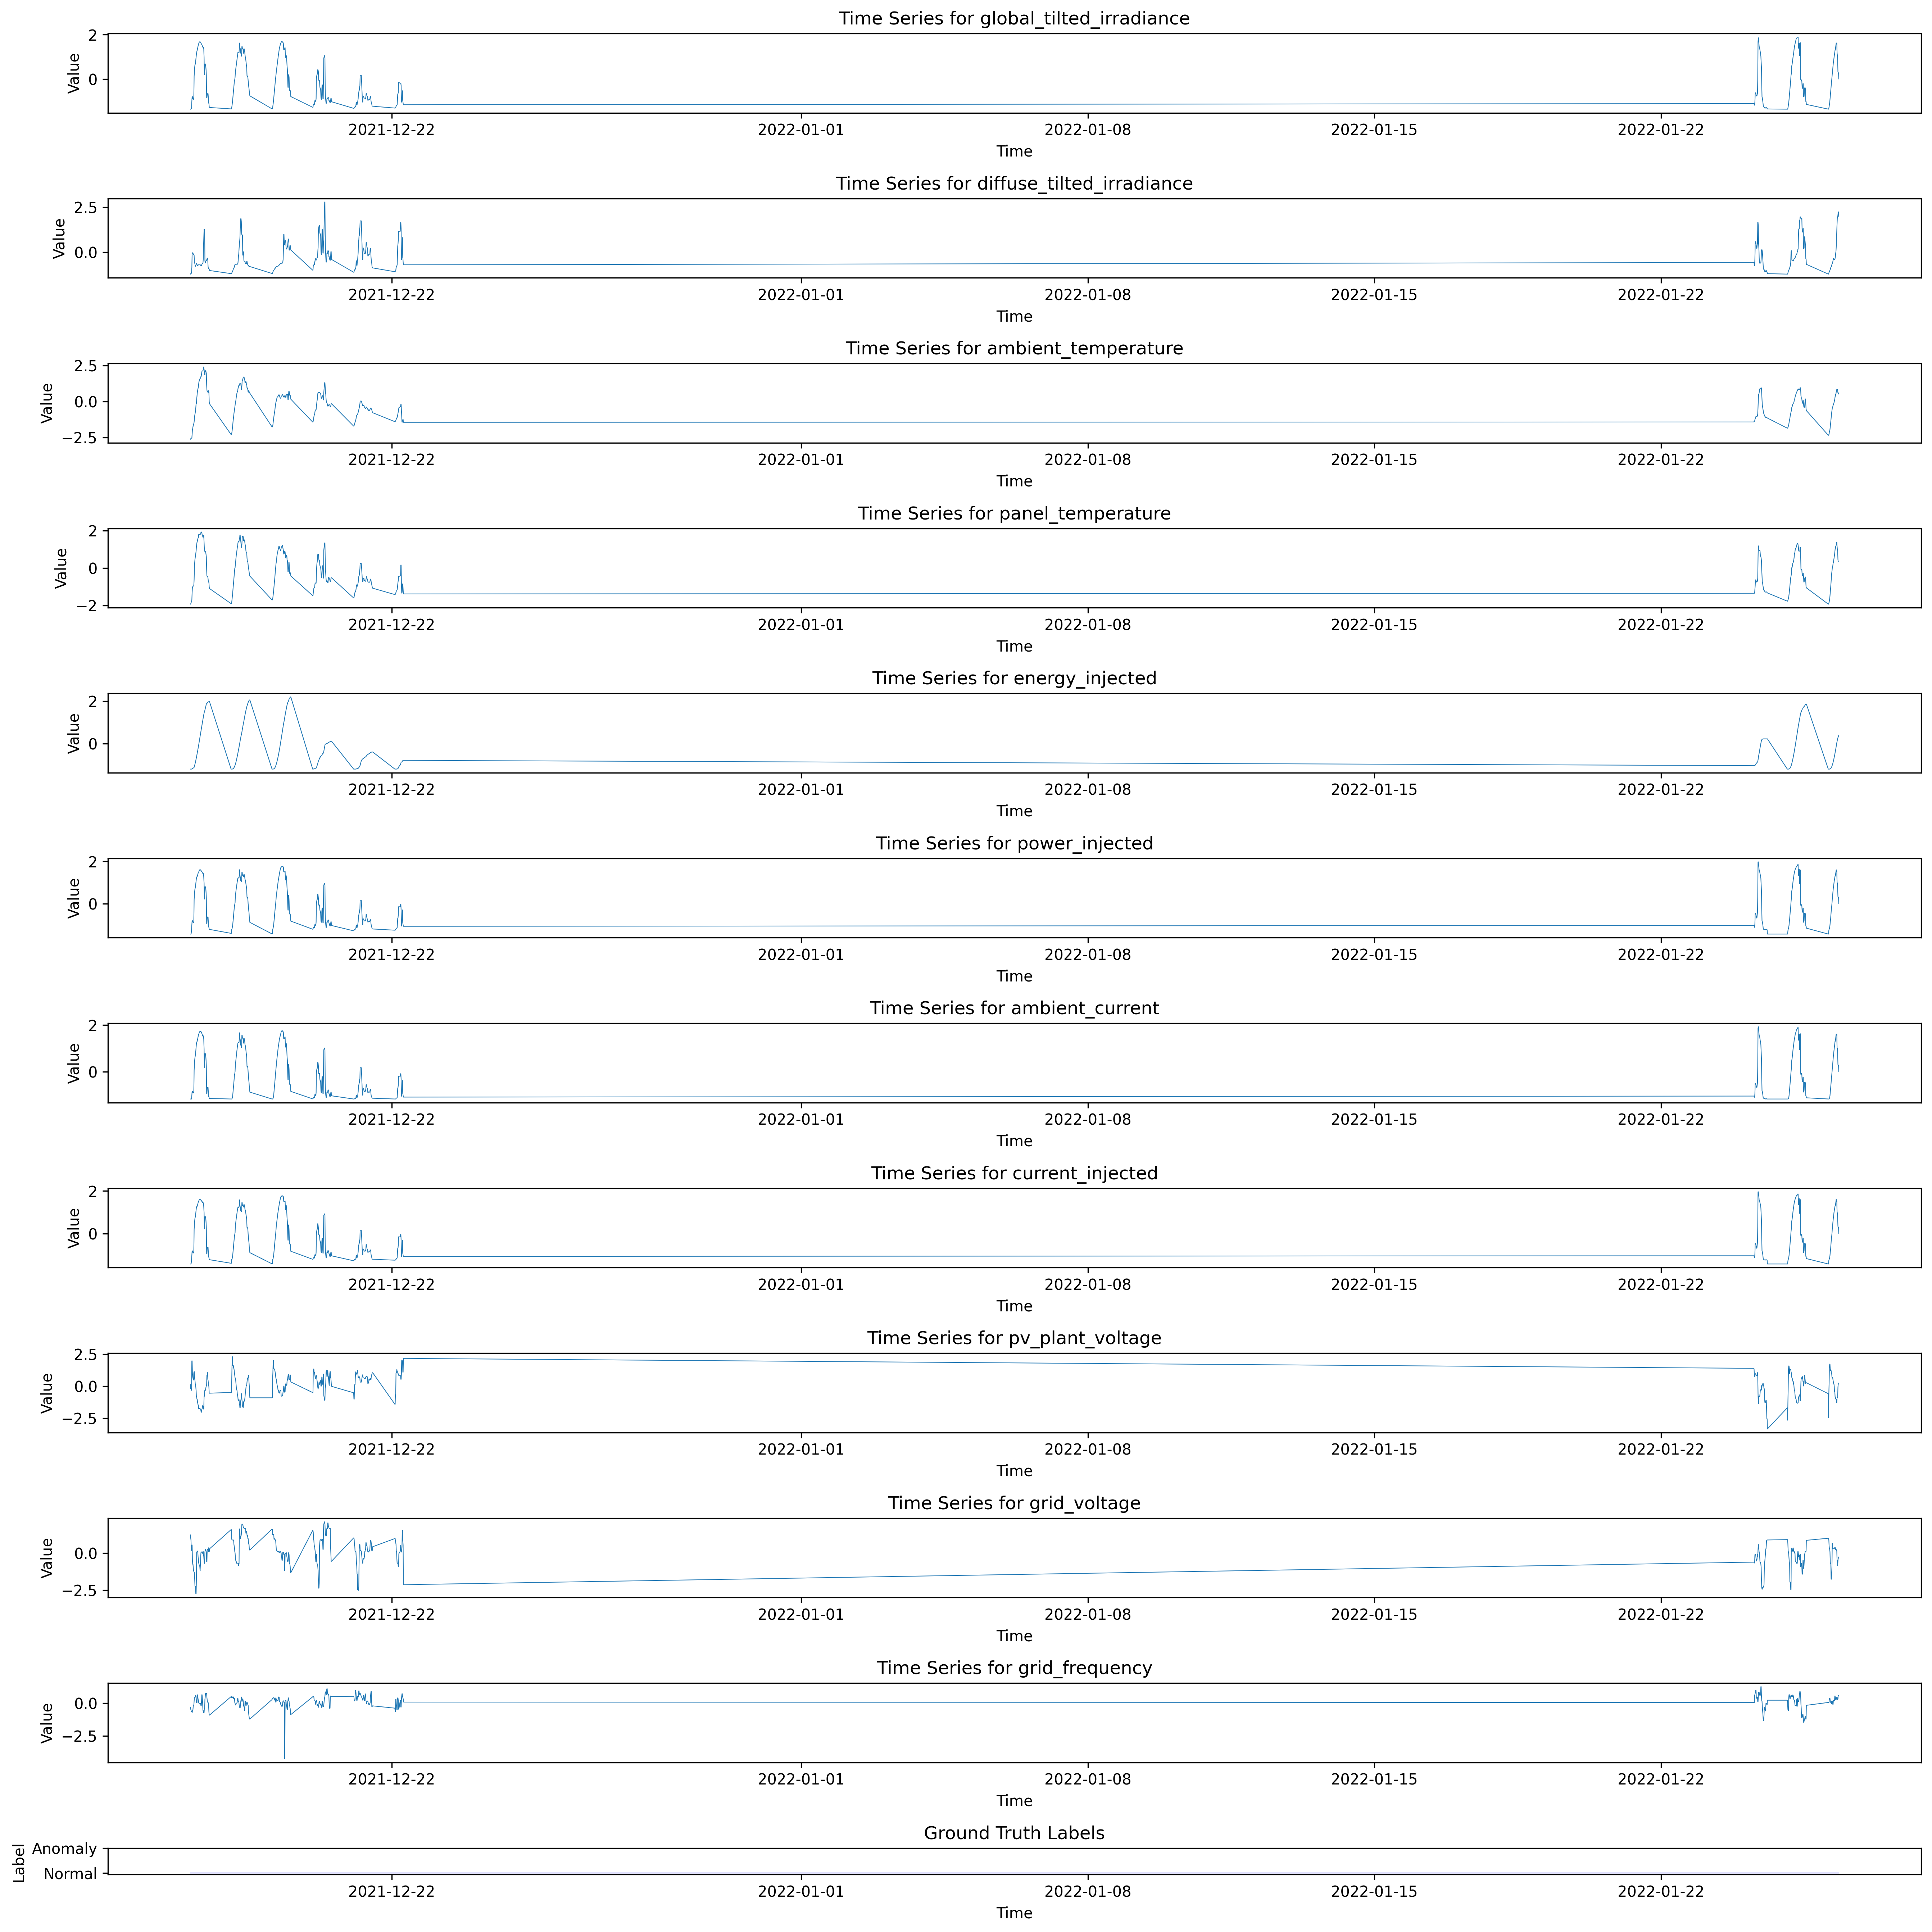

In [13]:
fold_num = 27
fold, model, train_set, labels = train_fold_data[fold_num]


train_set = train_set[:-model_params['validation_size']]
labels = labels[:-model_params['validation_size']]

# Usage example
plot_time_series_with_anomalies(train_set, labels, labels)